In [46]:
# imports and other setup

%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt

## Spracovanie dát z merania

Skript merania: `../../ML/prevodova_01`

Účel: prevodová charakteristika

In [47]:
# Údaje o predmetnom systéme

# Hardvér:
# Obslužná elektronika pre AeroShield, verzia mk1_v2502 (UNO a 12V zdroj)
# AeroShield, evidenčné číslo 6

# Vstupný signál:
# Rozsah: 0 až 100
# Jednotky: %
# Signál stanovuje striedu pulzno-šírkovej modulácie (PWM), ktorou je dané napájacie napätie jednosmerného motora.

# Výstupný signál:
# Rozsah (približne): -60 až 200 
# Jednotky: ° (uhol)
# Signál predstavuje polohu otočného ramena.

In [48]:
# -----------------------------------
# Dátový súbor:

data_file_path = './dataRepo/'

# data_file = 'dataFile_2025_02_20_10_45_54_copy.txt'
# data_file = 'dataFile_2025_02_20_14_12_35_copy.txt'
data_file = 'dataFile_2025_02_20_14_26_13_copy.txt'




# data_file_path = '../../ML/prevodova_v01/dataRepo/'
# data_file = 'dataFile__last.txt'

# -----------------------------------
# Hlavička dátového súboru, stĺpce:
# 
# 0 # čas vzorky podľa skriptu [sekunda]
# 1 # čas vzorky podľa mikrokontroléra [milisekunda]
# 2 # poloha doplnkového potenciometra [%] (rozsah 0 až 100%)
# 3 # výstupný signál [°] 
# 4 # vstupný signál [%]
# 5 # časový rozdiel od predchádzajúcej vzorky (podľa skriptu) [milisekunda]


# -----------------------------------
# Načítanie dát zo súboru:

dataRepoData = np.loadtxt(data_file_path + data_file, delimiter=',')

In [49]:
# -----------------------------------
# Iniciálna úprava dát - odstránenie úvodných vzoriek s nežiadúcou odchýlkou od ideálnej periódy vzorkovania.

avg_sample_time = np.mean(dataRepoData[:,5])

# Find all samples where the sample time is 25% greater than the average sample time
threshold = avg_sample_time * 1.25

# Create a temporary boolean mask
tmp_mask = dataRepoData[:, 5] > threshold

# Find the index of the last true value in tmp_mask that is not later than 5 seconds
time_limit = 5  # seconds
time_column = dataRepoData[:, 0]

# Create a mask for the time limit
time_mask = time_column <= time_limit

# Combine both masks
combined_mask = tmp_mask & time_mask

# Find the index of the last true value in the combined mask
last_true_index = np.where(combined_mask)[0][-1]

# Filter the data up to the last true index
dataRepoData = dataRepoData[last_true_index + 1:]


In [50]:

raw_time = dataRepoData[:,0]
raw_sig_in = dataRepoData[:,4]
raw_sig_out = dataRepoData[:,3]

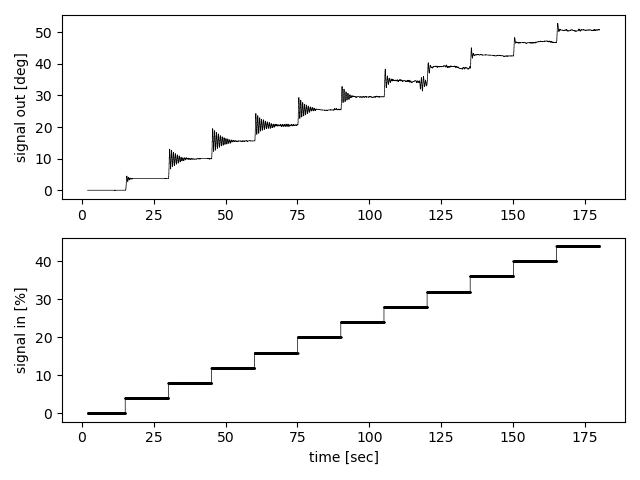

In [51]:
# -----------------------------------
# Kontrolné zobrazenie dát:

plt.figure(31)
plt.clf()


plt.subplot(211)

plt.plot(raw_time, raw_sig_out,
    marker='.', 
    ms=0,
    lw=0.5,
    color='black',
    drawstyle='steps-post',
    )

# plt.xlabel('time [sec]')
plt.ylabel('signal out [deg]')


plt.subplot(212)
plt.plot(raw_time, raw_sig_in,
    marker='.', 
    ms=1,
    lw=0.5,
    color='black',
    drawstyle='steps-post',
    )

plt.xlabel('time [sec]')
plt.ylabel('signal in [%]')

plt.tight_layout()
plt.show()

In [52]:
# -----------------------------------
# Skript pre získanie nameraných bodov prevodovej charakteristiky:

# Dostupné dáta:
# raw_time 
# raw_sig_in 
# raw_sig_out 

# Nastavenie:
ssTinterval = 5;


# Find the indices where the input signal changes
tmpdiffidx = np.where(np.diff(raw_sig_in) != 0)[0]

# Add the last index to tmpdiffidx to ensure the last segment is included
tmpdiffidx = np.append(tmpdiffidx, len(raw_sig_in)-1)


# Alokácia poľa pre jednotlivé body prevodovej charakteristiky
prevodova_mean = np.full((len(tmpdiffidx),2), np.nan)


tmp_couter = 0

for tmpidx in tmpdiffidx:

    tmptime_e = raw_time[tmpidx]
    tmptime_s = tmptime_e - ssTinterval

    tmp_mask = np.logical_and(raw_time >= tmptime_s, raw_time <= tmptime_e)

    prevodova_mean[tmp_couter,0] = np.mean(raw_sig_in[tmp_mask])
    prevodova_mean[tmp_couter,1] = np.mean(raw_sig_out[tmp_mask])
    tmp_couter += 1




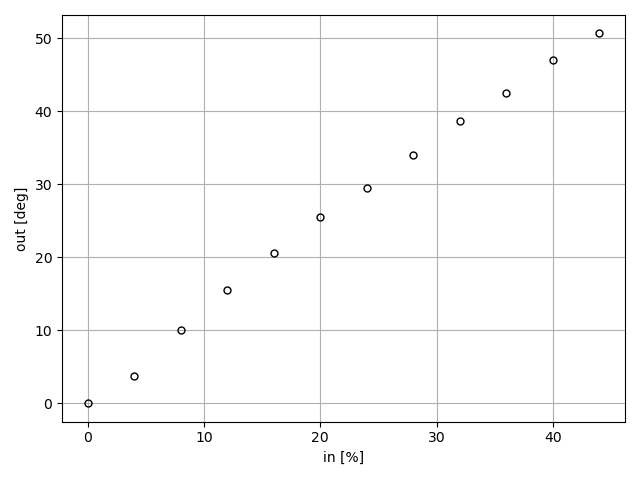

In [53]:
# -----------------------------------
# Zobrazenie nameraných bodov prevodovej charakteristiky:

plt.figure(32)
plt.clf()
plt.plot(prevodova_mean[:,0], prevodova_mean[:,1],
    color='black',
    marker='o', 
    ms=5,
    mec='black',
    mfc='None',
    lw=0,
    )

plt.xlabel('in [%]')
plt.ylabel('out [deg]')
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
np.savetxt(
    './dataRepo/results/' + 'prevodovaCh_from_' + data_file + '.txt', 
    prevodova_mean, 
    delimiter=',', 
    # header='Signal In [%], Signal Out [°]', 
    # comments=''
    )